In [ ]:
import pandas as pd
from auto_ml_regression.preprocessing import DataPreprocessor

data = pd.read_csv('../../datasets/LifeExpectancyData/LifeExpectancyData.csv')
target_col="Life expectancy "
N_SEGMENTS = 3
cols_to_del = ['Country']
data = data.drop(columns=cols_to_del).dropna(subset=target_col)

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация и применение препроцессора
preprocessor = DataPreprocessor(
    target_col=target_col,
    cat_encoder_type="target",  # или "ohe"
    fillna_num_strategy="mean",
    scaler_type="minmax",
    test_size=0.3,
    random_state=2025,
)

train_df, test_df = preprocessor.fit_transform(data)

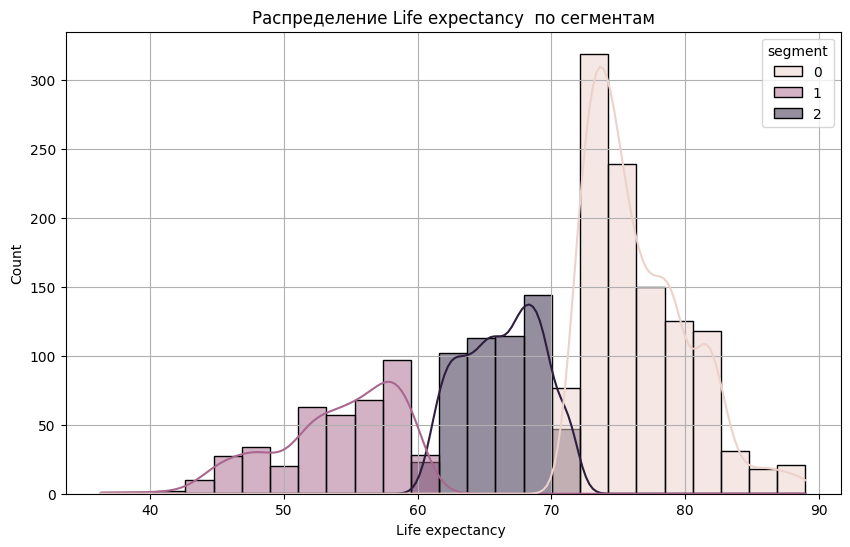

In [2]:
from auto_ml_regression.segmentation.kmeans import KMeansSegmenter

segmenter = KMeansSegmenter(N_SEGMENTS, plot=True)
segmented_train = segmenter.fit(train_df.copy(), target_col)

In [3]:
from auto_ml_regression.modeling.classifier import SegmentClassifier
from sklearn import metrics
import numpy as np

# ohe_cat_cols = list(set(segmented_train.columns) - set(num_features) - set(cat_features_saved) - set([target_col]))
# 2. Инициализация и обучение классификатора сегментов
clf = SegmentClassifier(
    features=num_features+cat_features_saved,
    cat_features=cat_features_saved, 
    n_segments=N_SEGMENTS
)

# Обучаем на сегментированных данных
clf.fit(
    X=segmented_train[num_features+cat_features_saved],
    y=segmented_train['segment'],
    n_trials=30  # Количество итераций Optuna
)


/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-20 23:12:44,436] A new study created in memory with name: no-name-e47ab1fc-884f-44b6-8746-ef9e5879c056
[I 2025-05-20 23:12:44,810] Trial 0 finished with value: 0.9867222696970827 and parameters: {'iterations': 360, 'learning_rate': 0.002254448213026115, 'l2_leaf_reg': 1.0418903012646539, 'random_strength': 0.10510545739446792, 'bagging_temperature': 4.208834469688868, 'border_count': 234, 'min_data_in_leaf': 41, 'leaf_estimation_iterations': 2, 'grow_policy': 'Depthwise', 'od_type': 'Iter', 'od_wait': 24, 'one_hot_max_size': 194, 'max_depth': 11}. Best is trial 0 with value: 0.9867222696970827.
[I 2025-05-20 23:12:45,194] Trial 1 finished with value: 0.9898498766641239 and parameters: {'iter

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1098
           1       1.00      1.00      1.00       408
           2       1.00      1.00      1.00       543

    accuracy                           1.00      2049
   macro avg       1.00      1.00      1.00      2049
weighted avg       1.00      1.00      1.00      2049

ROC AUC = 1.0


In [4]:
# 3. Предсказание на тестовых данных
# Сначала сегментируем тестовые данные (используем тот же segmenter)
segmented_test = segmenter.predict(test_df, target_col=target_col)
# Предсказание сегментов
test_segment_probs = clf.model.predict_proba(segmented_test[num_features+cat_features_saved])
test_segments = clf.model.predict(segmented_test[num_features+cat_features_saved])
segmented_test['segment_probs'] = test_segment_probs[:, 1]
segmented_test['segment_preds'] = test_segments 

print(f"TEST ROC AUC - {metrics.roc_auc_score(segmented_test['segment'], test_segment_probs, multi_class='ovr')}")#[:, 1]


TEST ROC AUC - 0.9902849013395154


In [5]:
from auto_ml_regression.modeling.linear_regs import SegmentLinearModels

lr = SegmentLinearModels(features=num_features+cat_features,
                         model_type='huber',
                         use_optuna=True,
                         n_trials=30,
                         cv=4)
lr.fit(segmented_train, 
       segmented_train[target_col], 
       segments=segmented_train['segment'])

[I 2025-05-20 23:14:53,018] A new study created in memory with name: no-name-c4945cd0-14ee-416f-afe6-0ef8c3453a00
[I 2025-05-20 23:14:53,641] Trial 0 finished with value: -2.235938478460566 and parameters: {'epsilon': 6.678686386372589, 'alpha': 0.04525261077172511, 'fit_intercept': True}. Best is trial 0 with value: -2.235938478460566.
[I 2025-05-20 23:14:54,290] Trial 1 finished with value: -2.236539725608207 and parameters: {'epsilon': 3.1336773971043184, 'alpha': 0.10501505496155517, 'fit_intercept': True}. Best is trial 0 with value: -2.235938478460566.
[I 2025-05-20 23:14:54,958] Trial 2 finished with value: -2.241193817674892 and parameters: {'epsilon': 3.9194686726925614, 'alpha': 0.2984574310907642, 'fit_intercept': True}. Best is trial 0 with value: -2.235938478460566.
[I 2025-05-20 23:14:55,183] Trial 3 finished with value: -6.388877058132661 and parameters: {'epsilon': 6.888129853235832, 'alpha': 0.2386904543349531, 'fit_intercept': False}. Best is trial 0 with value: -2.23

In [13]:
test_target_preds = lr.predict(segmented_test, 
                              segments=segmented_test['segment_preds']
                              )
                              # use_weighted=True,
                              # segment_probs=test_segment_probs

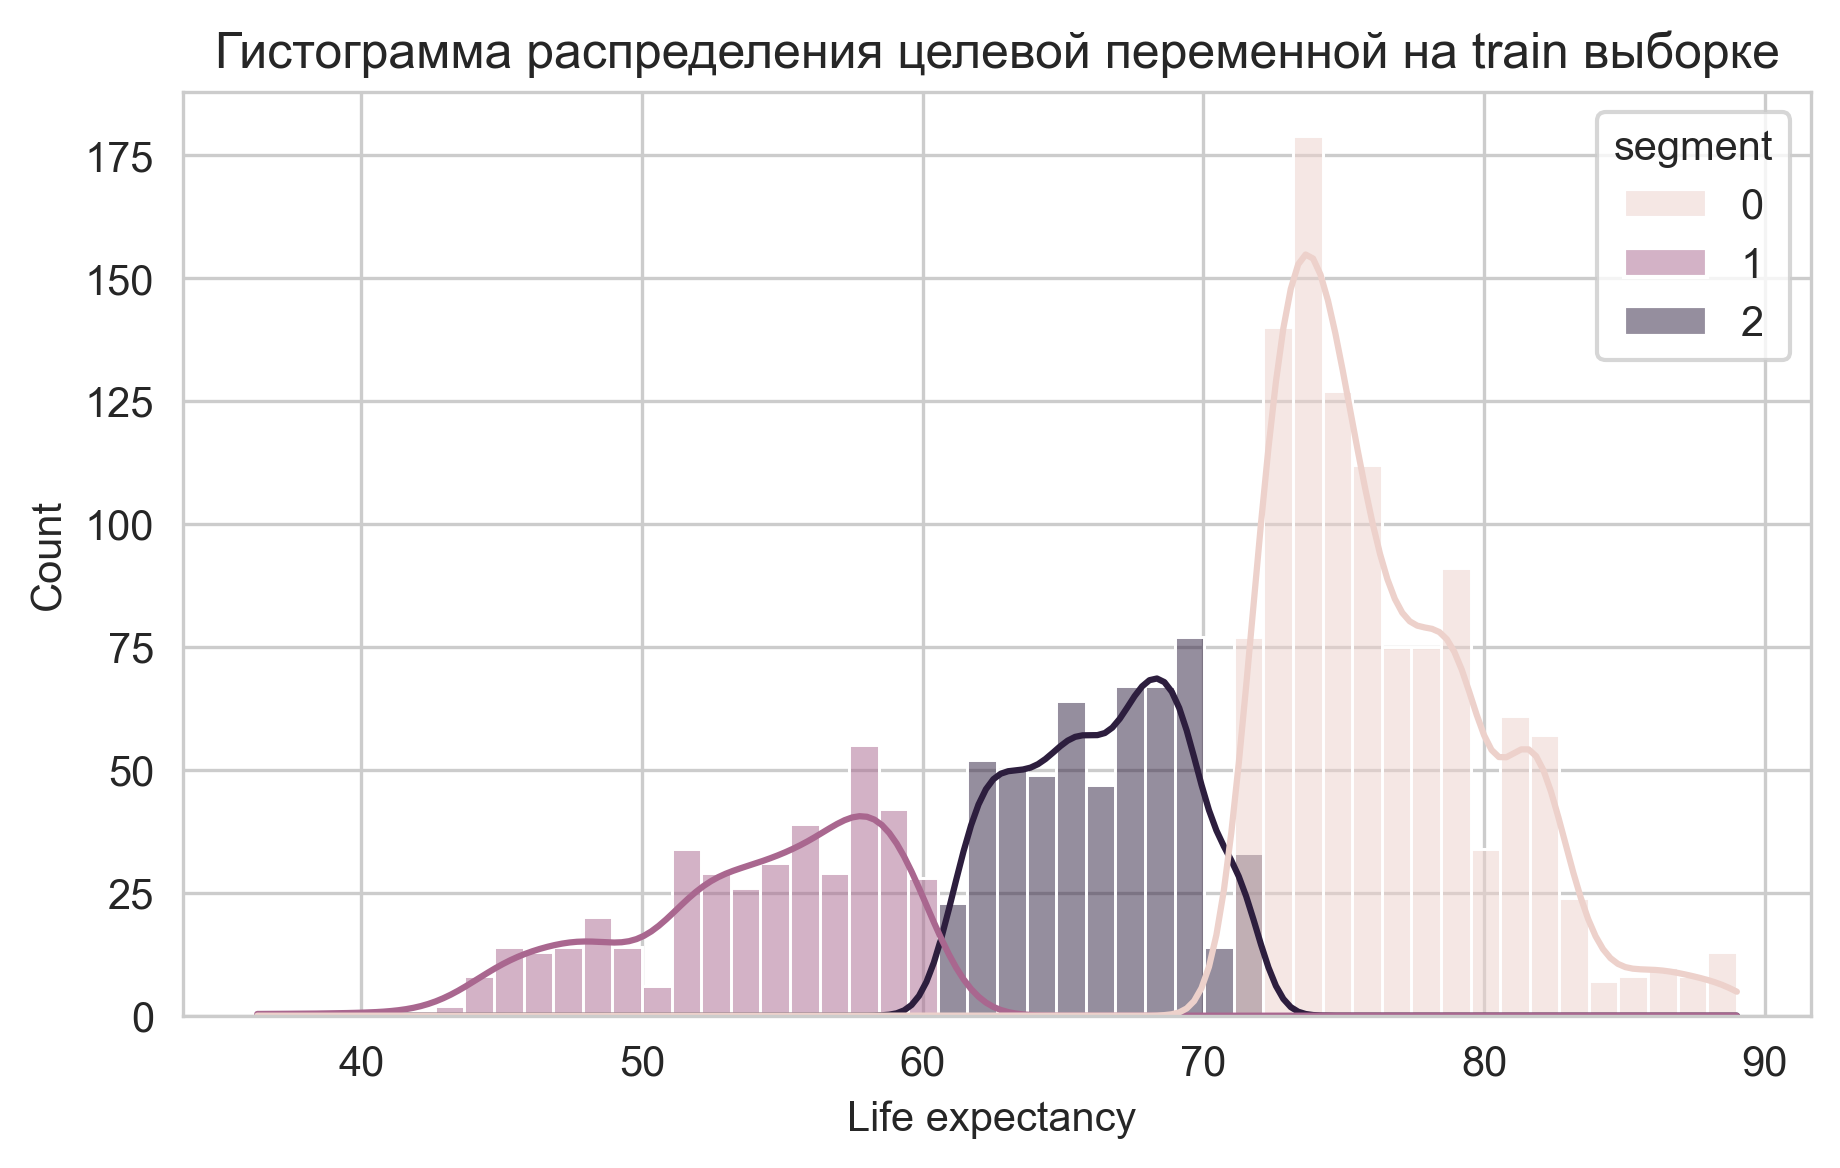

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной на train выборке")
sns.set_style("whitegrid")
sns.histplot(segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

In [15]:
lr.get_model_coefs()

,model_coef_segment_0,model_coef_segment_1,model_coef_segment_2
intercept_,72.893475,52.842190,61.655060
Year,1.443969,1.319659,-0.612244
Adult Mortality,-11.142954,-4.009284,-5.023040
infant deaths,-94.159361,72.417095,46.068923
Alcohol,-0.661680,-0.046037,0.258093
percentage expenditure,2.147504,92.523464,35.384599
Hepatitis B,-0.850802,-2.379420,0.108538
Measles,3.003633,-2.161433,-0.191679
BMI,-1.358063,5.381537,-0.237165
under-five deaths,89.548042,-76.684892,-48.116516


In [9]:
N = len(lr.models)
stat = pd.DataFrame(columns = [f'model_coef_segment_{m}' for m in range(N)],
             index = ['intercept_'] + list(lr.models[0].feature_names_in_))
for m in range(N):
     x = list([lr.models[m].intercept_])
     x.extend(list(lr.models[m].coef_))
     stat[f'model_coef_segment_{m}'] = x

stat

,model_coef_segment_0,model_coef_segment_1,model_coef_segment_2
intercept_,72.893475,52.842190,61.655060
Year,1.443969,1.319659,-0.612244
Adult Mortality,-11.142954,-4.009284,-5.023040
infant deaths,-94.159361,72.417095,46.068923
Alcohol,-0.661680,-0.046037,0.258093
percentage expenditure,2.147504,92.523464,35.384599
Hepatitis B,-0.850802,-2.379420,0.108538
Measles,3.003633,-2.161433,-0.191679
BMI,-1.358063,5.381537,-0.237165
under-five deaths,89.548042,-76.684892,-48.116516


In [10]:
test_target_true = segmented_test[target_col]

In [11]:
r2 = metrics.r2_score(test_target_true, test_target_preds)
mse = metrics.mean_squared_error(test_target_true, test_target_preds)
mae = metrics.mean_absolute_error(test_target_true, test_target_preds)
mape = metrics.mean_absolute_percentage_error(test_target_true, test_target_preds)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.9095114780416329
MSE = 8.118664385596054
RMSE = 2.8493270057324156
MAE = 2.0541284712741668
MAPE = 0.030973259873725487


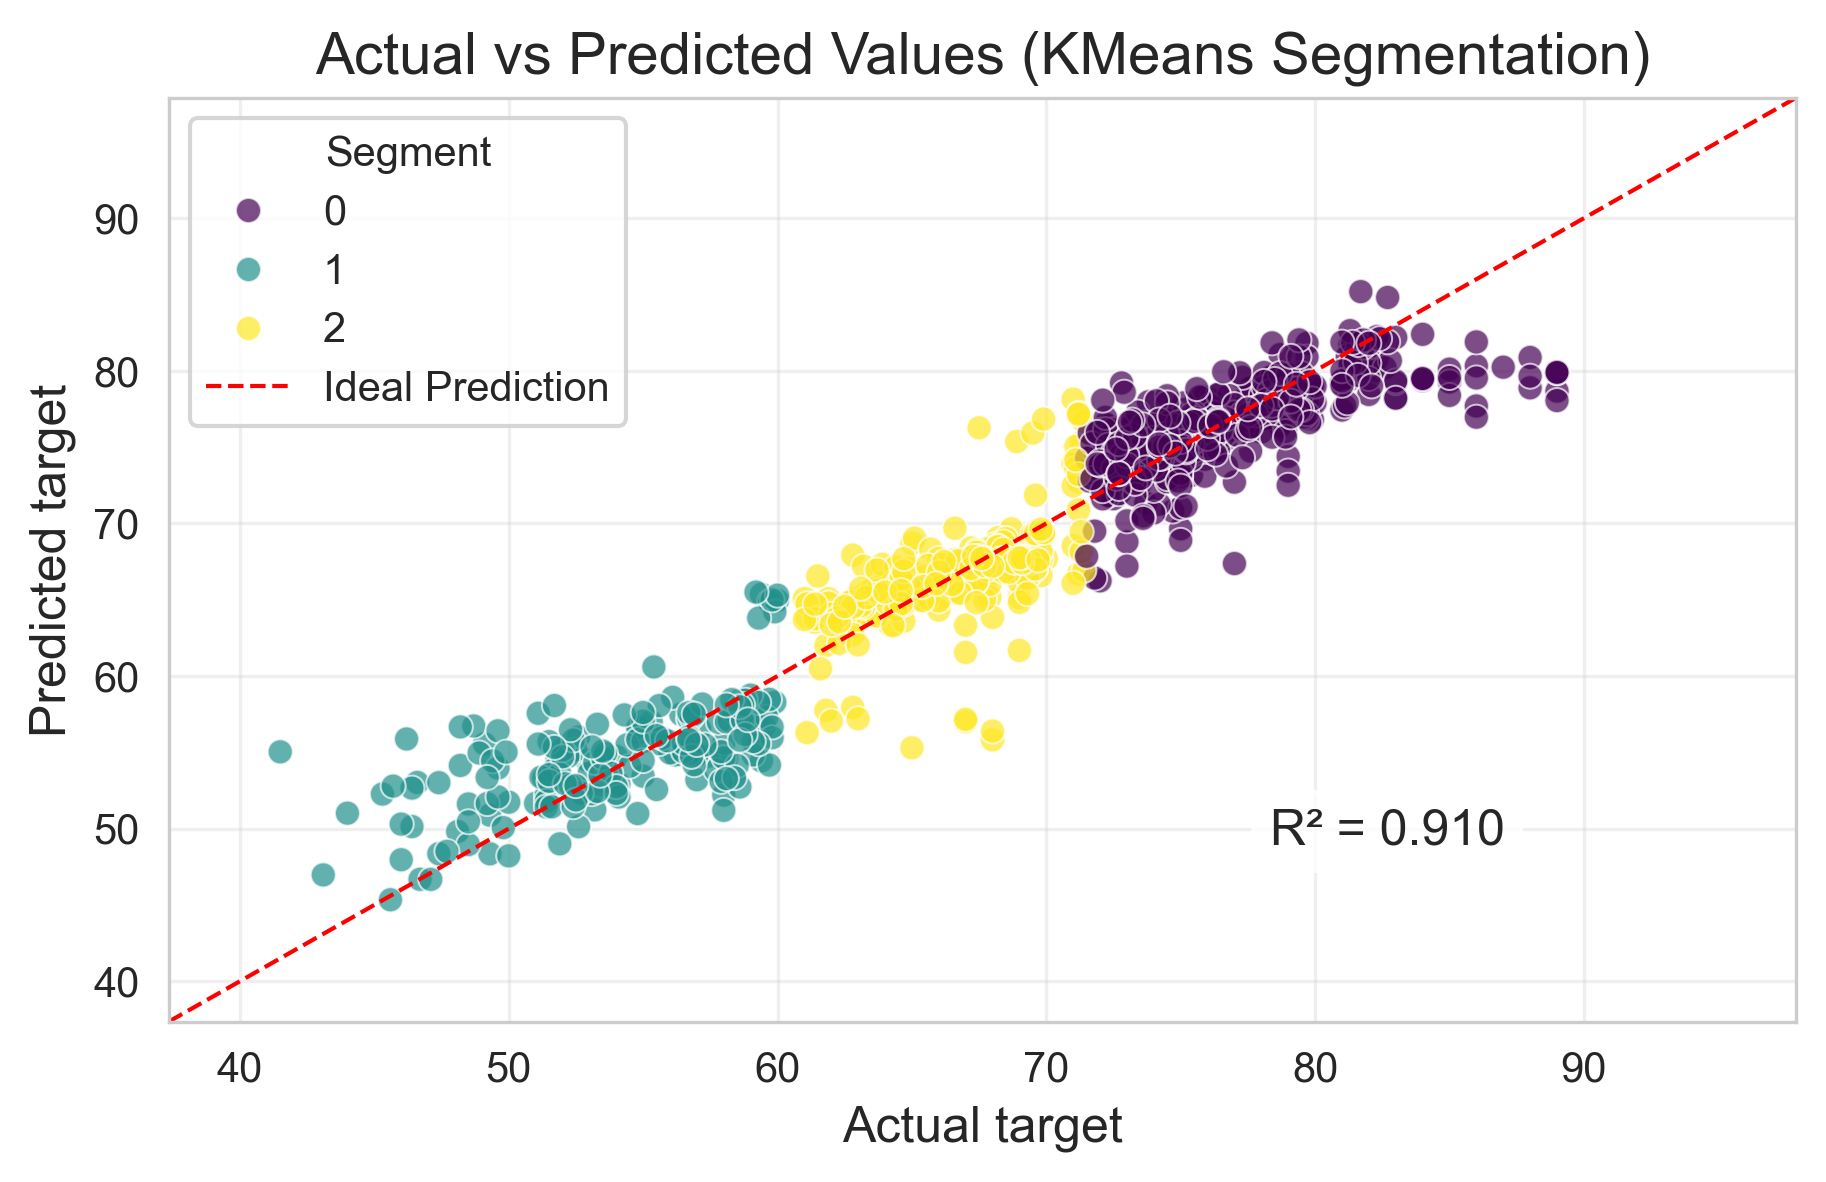

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = test_target_true
y_pred = test_target_preds

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual target', fontsize=12)
plt.ylabel('Predicted target', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.8,
    y=ax_max*0.5,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()